*Problem Statement*

With a set of 4 hydrophones located in a rectangle around the submarine center, how much does noise affect the predictions of the pinger heading?

In [1]:
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.stats import norm
import numpy as np
import math
import sympy
from mpl_toolkits import mplot3d

ModuleNotFoundError: No module named 'matplotlib'

We can expect a certain level of noise coming into this stage of the pipeline. For simulation purposes we will assume the detected times are normally distributed around their true value.

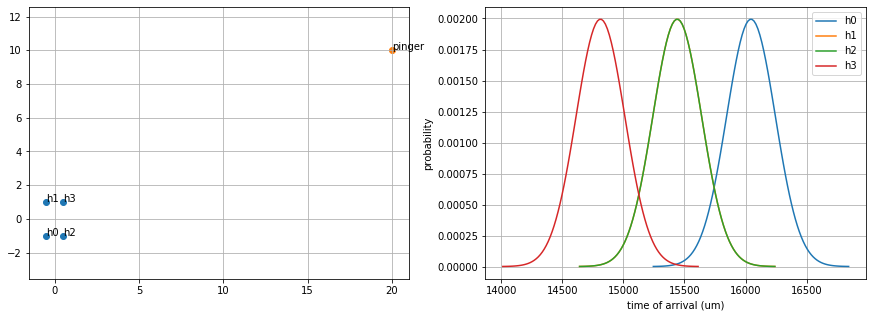

In [14]:
HYDRO_SIZE = (0.5, 1.0)
PINGER = (20, 10)
#this actually depends on the water composition, estimate in m/us
SOUND_VELOCITY = 0.00145
#standard deviation of measured times in microseconds
NOISE_STD = 200

hydros_x = [-HYDRO_SIZE[0], -HYDRO_SIZE[0], HYDRO_SIZE[0], HYDRO_SIZE[0]]
hydros_y = [-HYDRO_SIZE[1], HYDRO_SIZE[1], -HYDRO_SIZE[1], HYDRO_SIZE[1]]

#plot out the scenario of hydrophones and pinger
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots(1, 2)
ax[0].grid(True)
ax[0].axis('equal')
ax[0].scatter(hydros_x, hydros_y)
for i in range(0, 4):
    ax[0].annotate("h" + str(i), (hydros_x[i], hydros_y[i]))
    
ax[0].scatter(PINGER[0], PINGER[1])
ax[0].annotate("pinger", (PINGER[0], PINGER[1]))

#show distributions of arrival times in context
tm = [0, 0, 0, 0]
for i in range(0, 4):
    #find true time (in um)
    tm[i] = math.sqrt((hydros_x[i] - PINGER[0])**2 + (hydros_y[i] - PINGER[1])**2) / SOUND_VELOCITY
    dom = np.linspace(tm[i] - 4 * NOISE_STD, tm[i] + 4 * NOISE_STD, 100)
    ax[1].plot(dom, norm.pdf(dom, tm[i], NOISE_STD), label='h' + str(i))
    
ax[1].legend()
ax[1].set_xlabel('time of arrival (um)')
ax[1].set_ylabel('probability')
ax[1].grid(True)

For optimization purposes, we use a plane wave approximation. This has the helpful property of turning our transfer function from heading to time deltas into a linear transformation. We use a least squares error function on our three deltas (assuming h0 is at 0 us) and optimize while constraining the domain to a unit vector.

The full function to be minimized is as follows:

Where $h_n$ is the position of the hydrophone relative to origin, $\vec{o}$ is the observed time from each non-zero hydrophone, $\hat{x}$ is the unit vector pointing toward the pinger, and $v$ is the speed of sound,


$$A = \frac{-1}{v} \begin{bmatrix} h_{1} - h_{0} & h_{2} - h_{0} & h_{3} - h_{0} \end{bmatrix} ^ T$$
$$f(\hat{x}) = \begin{Vmatrix} (A\hat{x} - \vec{o}) \end{Vmatrix}^2$$

A good way of interpreting it is that $f(\hat{x})$ reaches a minimal value when the heading provides the closest approximation of the observed times, assuming some simplifications. Since this is a linear least squares problem, we can use the pseudoinverse of A to find the optimal heading.

In [15]:
#construct matrix for transformation between unit length heading and time deltas
h1vec = [hydros_x[1] - hydros_x[0], hydros_y[1] - hydros_y[0]]
h2vec = [hydros_x[2] - hydros_x[0], hydros_y[2] - hydros_y[0]]
h3vec = [hydros_x[3] - hydros_x[0], hydros_y[3] - hydros_y[0]]
trans = np.array([h1vec, h2vec, h3vec])
#scale matrix by velocity so that results are in us
trans *= (-1 / SOUND_VELOCITY)

#print with fancy LaTeX
sympy.init_printing()
sympy.Matrix(trans)

⎡       0.0         -1379.31034482759⎤
⎢                                    ⎥
⎢-689.655172413793         0.0       ⎥
⎢                                    ⎥
⎣-689.655172413793  -1379.31034482759⎦

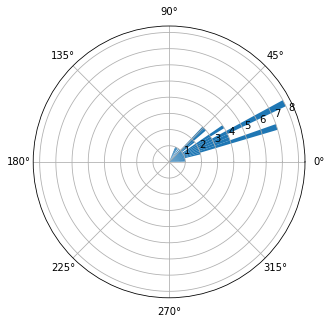

In [16]:
def heading_to_deltas(x, o):
    finalvec = np.dot(trans, x) - o
    return finalvec[0]**2 + finalvec[1]**2 + finalvec[2]**2

#calculate pseudoinverse of A
Adag = np.linalg.pinv(trans);

SAMPLE_NUM = 50
N = 360

samples = np.empty((SAMPLE_NUM, 2))

for i in range(0, SAMPLE_NUM):
    mod = (NOISE_STD * np.random.randn(4)) + tm

    observed = np.array([mod[1] - mod[0], mod[2] - mod[0], mod[3] - mod[0]])

    delta_min = np.dot(Adag, observed);
    
    samples[i] = delta_min

headings = np.arctan2(samples[:,1:2], samples[:,:1])
for i in range(0, SAMPLE_NUM):
    if headings[i] < 0:
        headings[i] = 2 * np.pi + headings[i]
        
bins_number = 120  # the [0, 360) interval will be subdivided into this
# number of equal bins
bins = np.linspace(0.0, 2 * np.pi, bins_number + 1)
n, _, _ = plt.hist(headings, bins)

plt.clf()
width = 2 * np.pi / bins_number
ax = plt.subplot(1, 1, 1, projection='polar')
bars = ax.bar(bins[:bins_number], n, width=width, bottom=0.0)
plt.show()

The above graph is a histogram of solved headings based on the distribution of times above.

# Uniform Array Beamforming DOA Estimation

In [13]:
#First take parameters of the environment, 
#and then generate samples with noise based on that

import numpy as np
import math

SAMP_LEN = 100
FREQ = 35000 #in hertz
ARRAY_SPACE = 0.02 #in meters
WAVE_VELOCITY = 1450 #in m/s
HEADING = math.pi/4 #in radians

#hydrophone positions
positions = np.array([\
    [ARRAY_SPACE/2,  ARRAY_SPACE/2],\
    [-ARRAY_SPACE/2, ARRAY_SPACE/2],\
    [-ARRAY_SPACE/2, -ARRAY_SPACE/2],\
    [ARRAY_SPACE/2,  -ARRAY_SPACE/2],\
])

#find relative distance from pinger perspective
ping_vector = np.array([math.cos(HEADING), math.sin(HEADING)]);
deltas_m = positions @ ping_vector
#convert to radians in phase difference
deltas_r = deltas_m * 2 * math.pi * FREQ / WAVE_VELOCITY
print(deltas_r)

[ 2.14484004e+00 -2.63093529e-16 -2.14484004e+00  2.63093529e-16]
